# 2. Preprocessin and Modeling for Capstone Three<a id='2_preprocessing_modeling'></a>

## 2.1 Contents<a id='2.1_Contents'></a>

* [2. Data Wrangling and EDA](#2_Data_wrangling_eda)
    * [2.1 Contents](#2.1_Contents)
    * [2.2 Introduction](#2.2_Introduction)
    * [2.3 Imports](#2.3_Imports)
        * [2.3.1 Import packages](#2.3.1_import_packages)
        * [2.3.2 Import JD and SP500 Time Series Data](#2.3.2_timeseries_data)
        
    * [2.4 Conduct Basic ARMA Modeling](#2.4_arma)
        * [2.4.1 JD ARMA Model](#2.4.1_jd_arma)
            * [2.4.1.1 JD AR Model Daily Data](#2.4.1.1_jd_ar_daily)
            * [2.4.1.2 JD AR Model Weekly Data](#2.4.1.2_jd_ar_weekly)
            * [2.4.1.3 JD Prices or returns = Random Walk?](#2.4.1.3_jd_random_walk)
            * [2.4.1.4 JD Prices or returns is stationary?](#2.4.1.4_jd_stationary)
            * [2.4.1.5 JD: Choosing the right model](#2.4.1.5_jd_choosing_model)
        * [2.4.2 SP500 ARMA Modeling](#2.4.2_sp_arma)
            * [2.4.2.1 SP500 AR Model Daily Data](#2.4.2.1_sp_ar_daily)
            * [2.4.2.2 SP500 AR Model Weekly Data](#2.4.2.2_sp_ar_weekly)
            * [2.4.2.3 SP500 Prices or returns = Random Walk?](#2.4.2.3_sp_random_walk)
            * [2.4.2.4 SP500 Prices or returns stationary?](#2.4.2.4_sp_stationary)
            * [2.4.2.5 SP500: Choosing the right model](#2.4.2.5_sp_choosing_model)
            * [2.4.2.6 SP500: Forecasting with an AR(7) model](#2.4.2.6_sp_forecasting_model)
        * [2.4.3 Cointegration of JD and SP500](#2.4.3_sp_jd)
        * [2.4.4 ARIMAX Model for SP500](#2.4.4_sp_arimax)
        * [2.4.5 SARIMAX Model for SP500](#2.4.5_sp_sarimax)
            * [2.4.5.1 SP500 in sample One Step Ahead forecast](#2.4.5.1_sp_sarimax_1day)
            * [2.4.5.2 SP500 in sample Dynamic forecast](#2.4.5.2_sp_sarimax_dynamic)
            * [2.4.5.3 SP500 out of sample One Step Ahead forecast](#2.4.5.3_sp_sarimax_1day)
            * [2.4.5.4 SP500 out of sample Dynamic forecast](#2.4.5.4_sp_sarimax_dynamic)
                       
     * [2.5 ARCH and GARCH Models](#2.5_garch)
     * [2.6 Resources to Review for future analysis](#2.5_review)        
    
        

## 2.2 Introduction  <a id='2.2_Introduction'></a>

For this stage of the capstone project, we want to explore modeling the Twitter sentiment data and JD.com stock and SP500 time series data.

Since we are still collecting Twitter sentiment data, we will proceed with time series analysis. Here we will try using ARMA and GARCH modeling.

## 2.3 Imports <a id='2.3_Imports'></a>

### 2.3.1 Import packages<a id='2.3.1_import_packages'></a>

In [560]:
#!pip install tweepy    # Installed this package on August 24 2021
#!pip install yfinance==0.1.63 # installed new version on August 25 2021
#!pip install statsmodels==0.12.2 installed new version on August 27 2021
#!pip install arch installed new version on August 28 2021
import re
import tweepy, json
import pandas as pd
import numpy as np
import os
import yfinance as yf
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psycopg2
import datetime as dt
from dateutil.parser import parse
import datetime
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

In [316]:
!pip list


Package                            Version            
---------------------------------- -------------------
aiobotocore                        1.3.3              
aiohttp                            3.7.4.post0        
aioitertools                       0.7.1              
alabaster                          0.7.12             
anaconda-client                    1.7.2              
anaconda-navigator                 1.9.12             
anaconda-project                   0.8.3              
applaunchservices                  0.2.1              
appnope                            0.1.0              
appscript                          1.0.1              
argh                               0.26.2             
asn1crypto                         1.3.0              
astroid                            2.3.3              
astropy                            4.0                
async-timeout                      3.0.1              
atomicwrites                       1.3.0              
attrs     

### 2.3.2 Import JD and SP500 Time Series Data<a id='2.3.2_timeseries_data'></a>

In [317]:
# Import both JD and SPY time series data

jd_price = pd.read_csv('jd_price.csv')
sp_price = pd.read_csv('sp_price.csv')

jd_price['Date'] = pd.to_datetime(jd_price['Date'])
sp_price['Date'] = pd.to_datetime(sp_price['Date'])

jd_price.set_index('Date', inplace=True)
sp_price.set_index('Date', inplace=True)

In [318]:
jd_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 665 entries, 2019-01-02 to 2021-08-20
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Open                         665 non-null    float64
 1   High                         665 non-null    float64
 2   Low                          665 non-null    float64
 3   Close                        665 non-null    float64
 4   Adj Close                    665 non-null    float64
 5   Volume                       665 non-null    int64  
 6   high_minus_low               665 non-null    float64
 7   high_minus_low_pct_adjclose  665 non-null    float64
 8   lagged_1                     664 non-null    float64
 9   lagged_5                     660 non-null    float64
 10  lagged_10                    655 non-null    float64
 11  lagged_20                    645 non-null    float64
 12  shifted_1                    664 non-null    float64
 13  s

In [319]:
sp_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 665 entries, 2019-01-02 to 2021-08-20
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Open                         665 non-null    float64
 1   High                         665 non-null    float64
 2   Low                          665 non-null    float64
 3   Close                        665 non-null    float64
 4   Adj Close                    665 non-null    float64
 5   Volume                       665 non-null    int64  
 6   high_minus_low               665 non-null    float64
 7   high_minus_low_pct_adjclose  665 non-null    float64
 8   lagged_1                     664 non-null    float64
 9   lagged_5                     660 non-null    float64
 10  lagged_10                    655 non-null    float64
 11  lagged_20                    645 non-null    float64
 12  shifted_1                    664 non-null    float64
 13  s

## 2.4 Conduct Basic ARMA Modeling<a id='2.4_arma'></a>

### 2.4.1 JD ARMA Model<a id='2.4.1_jd_arma'></a>

#### 2.4.1.1 JD AR Model Daily Data<a id='2.4.1.1_jd_ar_daily'></a>

In [320]:
jd_price

,Open,High,Low,Close,Adj Close,Volume,high_minus_low,high_minus_low_pct_adjclose,lagged_1,lagged_5,...,pct_change_20,50_ma,100_ma,200_ma,50_std,100_std,200_std,cumulative_return,up_or_down,consecutive_count
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,20.309999,21.480000,20.180000,21.270000,21.270000,15840000,1.299999,6.111891,20.350000,23.690001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOWN,1
2019-01-03,20.889999,21.139999,20.250000,20.350000,20.350000,18608000,0.889999,4.373461,22.270000,23.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.325341,DOWN,2
2019-01-04,20.980000,22.680000,20.750000,22.270000,22.270000,25156900,1.930000,8.666369,22.760000,22.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.701457,UP,1
2019-01-07,22.430000,22.850000,22.260000,22.760000,22.760000,18889800,0.590000,2.592268,22.950001,22.040001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.005170,UP,2
2019-01-08,22.990000,23.180000,22.434999,22.950001,22.950001,15180400,0.745001,3.246191,23.690001,22.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.898450,UP,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-16,68.209999,68.220001,64.800003,66.669998,66.669998,12498500,3.419998,5.129741,64.260002,NaN,...,-10.172464,72.8560,74.6220,81.91930,3.100210,4.107937,9.032637,213.446153,DOWN,4
2021-08-17,64.150002,65.529999,63.020000,64.260002,64.260002,13386000,2.509998,3.906004,65.529999,NaN,...,-13.009341,72.6476,74.4775,81.82540,3.317691,4.215425,9.118138,202.115659,DOWN,5
2021-08-18,65.000000,66.290001,63.994999,65.529999,65.529999,9352500,2.295002,3.502216,62.189999,NaN,...,-12.974773,72.4926,74.3121,81.74545,3.465296,4.238933,9.190643,208.086494,UP,1


In [321]:
jd_price.pct_change_1.head()

Date
2019-01-02         NaN
2019-01-03   -4.325341
2019-01-04    9.434890
2019-01-07    2.200268
2019-01-08    0.834800
Name: pct_change_1, dtype: float64

In [322]:
# Obtain daily returns for JD.com

jd_returns = jd_price.pct_change_1.div(100).dropna()

In [323]:
jd_returns

Date
2019-01-03   -0.043253
2019-01-04    0.094349
2019-01-07    0.022003
2019-01-08    0.008348
2019-01-09    0.032244
                ...   
2021-08-16   -0.045663
2021-08-17   -0.036148
2021-08-18    0.019763
2021-08-19   -0.050969
2021-08-20    0.022994
Name: pct_change_1, Length: 664, dtype: float64

In [324]:
# Compute autocorrelation of returns

jd_autocorrelation = jd_returns.autocorr()
print("The autocorrelation of daily returns is %4.2f" %(jd_autocorrelation))

The autocorrelation of daily returns is -0.07


The approximate confidence interval is +/- 0.08


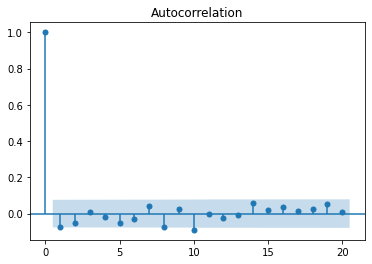

In [325]:
# Find the number of observations by taking the length of the returns DataFrame
nobs = len(jd_returns)

# Compute the approximate confidence interval
conf = 1.96/sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(jd_returns, alpha=0.05, lags=20)
plt.show()

Daily returns do not appear to have any autocorrelation for JD.com

#### 2.4.1.2 JD AR Model Weekly Data<a id='2.4.1.2_jd_ar_weekly'></a>

In [326]:
jd_weekly_returns = jd_price['Adj Close'].resample(rule='W').last().pct_change().dropna()

In [327]:
jd_weekly_returns

Date
2019-01-13    0.027391
2019-01-20    0.016608
2019-01-27    0.015907
2019-02-03    0.042319
2019-02-10   -0.025985
                ...   
2021-07-25   -0.043657
2021-08-01   -0.019505
2021-08-08   -0.018200
2021-08-15    0.003880
2021-08-22   -0.089322
Freq: W-SUN, Name: Adj Close, Length: 137, dtype: float64

In [328]:
# Compute autocorrelation of returns

jd_autocorrelation_weekly = jd_weekly_returns.autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(jd_autocorrelation_weekly))

The autocorrelation of weekly returns is -0.08


The approximate confidence interval is +/- 0.17


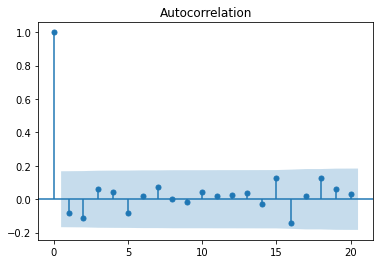

In [329]:
# Find the number of observations by taking the length of the returns DataFrame
nobs = len(jd_weekly_returns)

# Compute the approximate confidence interval
conf = 1.96/sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(jd_weekly_returns, alpha=0.05, lags=20)
plt.show()

JD.com weekly returns appears to have zero autocorrelation at all lags

#### 2.4.1.3 JD Prices or returns = Random Walk?<a id='2.4.1.3_jd_random_walk'></a>

In [330]:
# Run the ADF test on the price series and print out the results

results = adfuller(jd_price['Adj Close'])
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(-1.2155196454795996, 0.6668841760145332, 5, 659, {'1%': -3.4403119951958754, '5%': -2.8659357770630662, '10%': -2.5691109142928195}, 2529.8586388270987)
The p-value of the test on prices is: 0.6668841760145332


We cannot reject the null hypothesis that JD.com prices follows a random walk.

In [331]:
# Run the ADF test on the returns series and print out the results

results = adfuller(jd_price['pct_change_1'].div(100).dropna())
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(-19.8745111794351, 0.0, 1, 662, {'1%': -3.4402666733359175, '5%': -2.8659158113822065, '10%': -2.569100276740811}, -2780.2778346121186)
The p-value of the test on prices is: 0.0


Here we can see that JD.com returns have a small p-value less than 5%, so we can reject the null that the returns follow a random walk.

#### 2.4.1.4 JD Prices or returns stationary?<a id='2.4.1.4_jd_stationary'></a>

**Weak stationarity:** mean, variance and autocorrelation are time-invariant

**Another definition**
 1. Trend is zero
 2. Variance is constant
 3. Autocorrelation is constant

<AxesSubplot:xlabel='Date'>

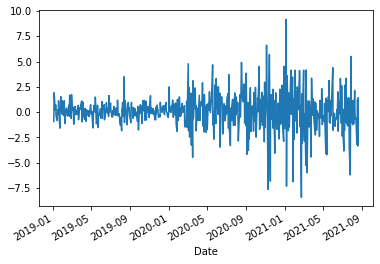

In [332]:
jd_price['Adj Close'].diff().plot()

The first diffrence of JD.com may not be stationary due to increaed volatility in 2021

<AxesSubplot:xlabel='Date'>

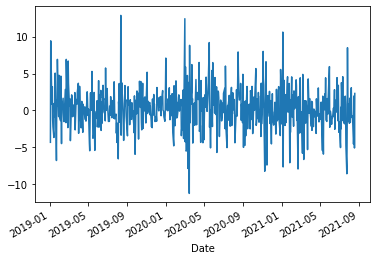

In [333]:
jd_price.pct_change_1.plot()

In [334]:
# ADfuller test

jd_daily_ADF = adfuller(jd_price.pct_change_1.dropna())
print(jd_daily_ADF)

(-19.874511179435103, 0.0, 1, 662, {'1%': -3.4402666733359175, '5%': -2.8659158113822065, '10%': -2.569100276740811}, 3141.971024568567)


JD 1 day returns appear to be stationary based on Dickey Fuller Test

<AxesSubplot:xlabel='Date'>

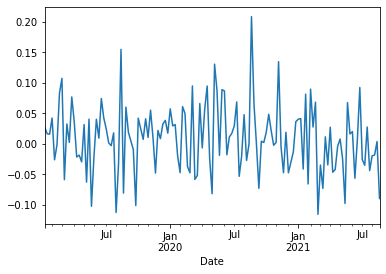

In [335]:
jd_weekly_returns.plot()

In [336]:
# ADfuller test

jd_weekly_ADF = adfuller(jd_weekly_returns)
print(jd_weekly_ADF)

(-12.459706058851785, 3.427703180948313e-23, 0, 136, {'1%': -3.4793722137854926, '5%': -2.8830370378332995, '10%': -2.578233635380623}, -358.97745808669936)


JD weekly returns may be stationary based on the Dickey Fuller test.

#### 2.4.1.5 JD: Choosing the right model<a id='2.4.1.5_jd_choosing_model'></a>

We can use PACF or Information Criteria(AIC or BIC) to accomplish this.

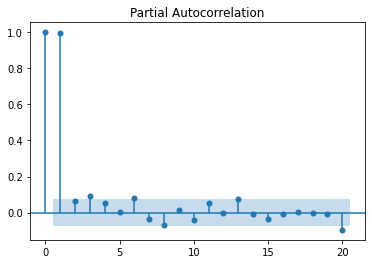

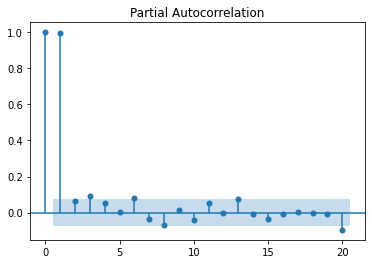

In [337]:
# plot PACF for daily prices

plot_pacf(jd_price['Adj Close'], lags=20)

JD Price appears to have an AR(1) parameter

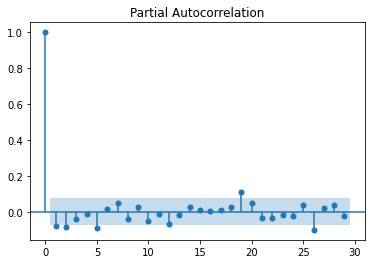

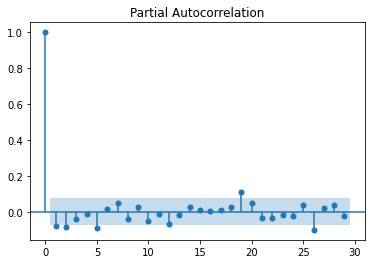

In [338]:
# plot PACF for daily difference in price
plot_pacf(jd_price['Adj Close'].diff().dropna())

JD 1 day Price difference does not have a significant partial autocorrelation

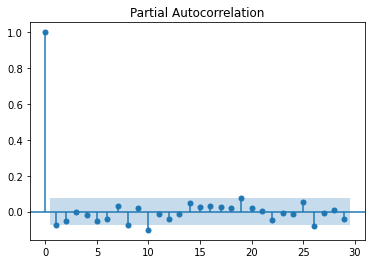

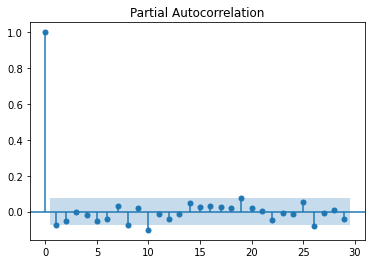

In [339]:
# plot PACF for daily return

plot_pacf(jd_price.pct_change_1.dropna())

JD 1 day return does not have a significant PACF

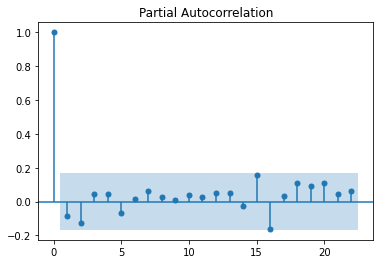

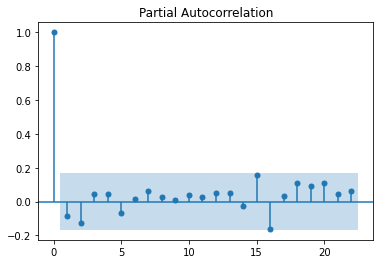

In [340]:
# plot PACF for weekly return
plot_pacf(jd_weekly_returns)

JD 1 week returns do not appear to have a significant PACF

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/li

Text(0, 0.5, 'Bayesian Information Criterion')

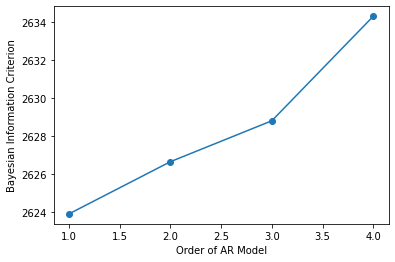

In [341]:
# Check BIC measure for different AR(p) processes for JD prices

BIC = np.zeros(5)
for p in range(5):
    mod = ARMA(jd_price['Adj Close'], order=(p,0))
    res = mod.fit()
    BIC[p] = res.bic

    # Plot the BIC as a function of p
plt.plot(range(1,5), BIC[1:5], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/li

Text(0, 0.5, 'Bayesian Information Criterion')

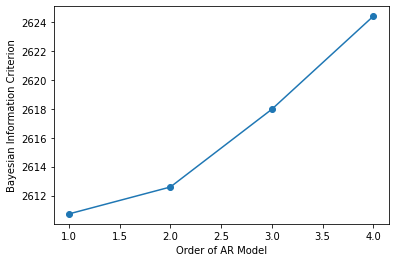

In [342]:
# Check BIC measure for different AR(p) processes for JD prices difference

BIC = np.zeros(5)
for p in range(5):
    mod = ARMA(jd_price['Adj Close'].diff().dropna(), order=(p,0))
    res = mod.fit()
    BIC[p] = res.bic

    # Plot the BIC as a function of p
plt.plot(range(1,5), BIC[1:5], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/li

Text(0, 0.5, 'Bayesian Information Criterion')

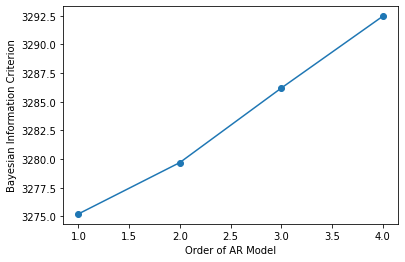

In [343]:
# Check BIC measure for different AR(p) processes for JD daily returns

BIC = np.zeros(5)
for p in range(5):
    mod = ARMA(jd_price.pct_change_1.dropna(), order=(p,0))
    res = mod.fit()
    BIC[p] = res.bic

    # Plot the BIC as a function of p
plt.plot(range(1,5), BIC[1:5], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')

Text(0, 0.5, 'Bayesian Information Criterion')

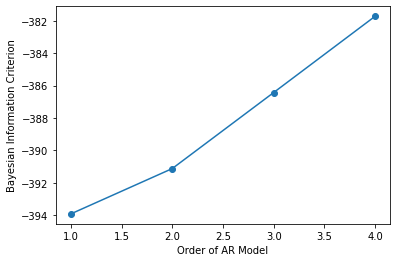

In [344]:
# Check BIC measure for different AR(p) processes for JD weekly returns

BIC = np.zeros(5)
for p in range(5):
    mod = ARMA(jd_weekly_returns, order=(p,0))
    res = mod.fit()
    BIC[p] = res.bic

    # Plot the BIC as a function of p
plt.plot(range(1,5), BIC[1:5], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')

Consistent with the PACF plots, there are no JD scenarios tested had a significant AR(p) model

### 2.4.2 SP500 ARMA Model<a id='2.4.2_sp_arma'></a>

#### 2.4.2.1 SP500 AR Model Daily Data<a id='2.4.2.1_sp_ar_daily'></a>

In [345]:
sp_price.pct_change_1.head()

Date
2019-01-02         NaN
2019-01-03   -2.386282
2019-01-04    3.349563
2019-01-07    0.788481
2019-01-08    0.939539
Name: pct_change_1, dtype: float64

In [346]:
# Obtain daily returns for SP500

sp_returns = sp_price.pct_change_1.div(100).dropna()

In [347]:
# Compute autocorrelation of returns

sp_autocorrelation = sp_returns.autocorr()
print("The autocorrelation of daily returns is %4.2f" %(sp_autocorrelation))

The autocorrelation of daily returns is -0.28


The approximate confidence interval is +/- 0.08


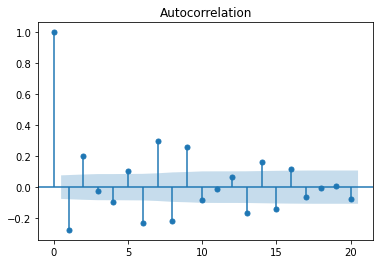

In [348]:
# Find the number of observations by taking the length of the returns DataFrame
nobs = len(sp_returns)

# Compute the approximate confidence interval
conf = 1.96/sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(sp_returns, alpha=0.05, lags=20)
plt.show()

Daily SP500 returns appear to be autocorrelated and mean reverts.

#### 2.4.2.2 SP500 AR Model Weekly Data<a id='2.4.2.2_sp_ar_weekly'></a>

In [349]:
sp_weekly_returns = sp_price['Adj Close'].resample(rule='W').last().pct_change().dropna()

In [350]:
sp_weekly_returns

Date
2019-01-13    0.026111
2019-01-20    0.028883
2019-01-27   -0.002552
2019-02-03    0.016103
2019-02-10    0.001518
                ...   
2021-07-25    0.019938
2021-08-01   -0.003250
2021-08-08    0.009076
2021-08-15    0.007752
2021-08-22   -0.005741
Freq: W-SUN, Name: Adj Close, Length: 137, dtype: float64

In [351]:
# Compute autocorrelation of returns

sp_autocorrelation_weekly = sp_weekly_returns.autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(sp_autocorrelation_weekly))

The autocorrelation of weekly returns is -0.10


The approximate confidence interval is +/- 0.17


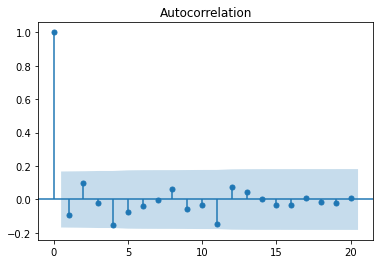

In [352]:
# Find the number of observations by taking the length of the returns DataFrame
nobs = len(sp_weekly_returns)

# Compute the approximate confidence interval
conf = 1.96/sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(sp_weekly_returns, alpha=0.05, lags=20)
plt.show()

SP500 returns appear to have zero autocorrelation at all lags. This could be a white noies series

#### 2.4.2.3 SP500 Prices or returns = Random Walk?<a id='2.4.2.3_sp_random_walk'></a>

In [353]:
# Run the ADF test on the price series and print out the results

results = adfuller(sp_price['Adj Close'])
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(-0.30532061840516517, 0.9247473857600015, 9, 655, {'1%': -3.4403730727154724, '5%': -2.86596268312982, '10%': -2.569125249694074}, 3578.255780050189)
The p-value of the test on prices is: 0.9247473857600015


We cannot reject the null hypothesis that SP500 prices follows a random walk.

In [354]:
# Run the ADF test on the returns series and print out the results

results = adfuller(sp_price['pct_change_1'].div(100).dropna())
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(-7.246449131704353, 1.8269536552325536e-10, 8, 655, {'1%': -3.4403730727154724, '5%': -2.86596268312982, '10%': -2.569125249694074}, -3753.2905121099957)
The p-value of the test on prices is: 1.8269536552325536e-10


Here we can see that SP500 returns have a small p-value less than 5%, so we can reject the null that the returns follow a random walk.

#### 2.4.2.4 SP500 Prices or returns stationary?<a id='2.4.2.4_sp_stationary'></a>

**Weak stationarity:** mean, variance and autocorrelation are time-invariant

<AxesSubplot:xlabel='Date'>

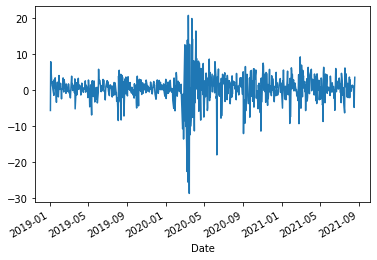

In [355]:
sp_price['Adj Close'].diff().plot()

SP500 first difference prices do not appear to be stationary due to the coronavirus event back in Q1 of 2020. Otherwise it does. However it looks likethere may have been a regime change after Q2 2020.

<AxesSubplot:xlabel='Date'>

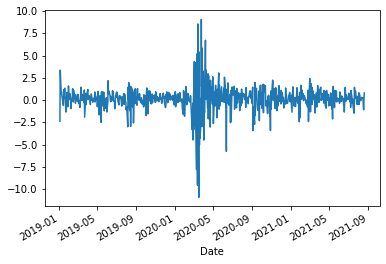

In [356]:
sp_price.pct_change_1.plot()

In [357]:
# ADfuller test

sp_daily_ADF = adfuller(sp_price.pct_change_1.dropna())
print(sp_daily_ADF)

(-7.2464491317043676, 1.8269536552324073e-10, 8, 655, {'1%': -3.4403730727154724, '5%': -2.86596268312982, '10%': -2.569125249694074}, 2168.9583470706893)


SP500 1 day returns do not appear to be stationary based on the graph but the Dickey Fuller test confirms we can reject the null that the series is not stationary

<AxesSubplot:xlabel='Date'>

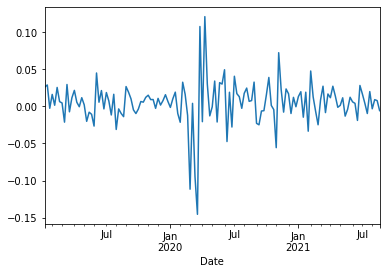

In [358]:
sp_weekly_returns.plot()

In [359]:
# ADfuller test

sp_weekly_ADF = adfuller(sp_weekly_returns)
print(sp_weekly_ADF)

(-12.756007922982658, 8.336899705653461e-24, 0, 136, {'1%': -3.4793722137854926, '5%': -2.8830370378332995, '10%': -2.578233635380623}, -505.108969577714)


SP500 weekly returns do not appear to be stationary due to the coronavirus event back in Q1 of 2020 as displayed on the graph. However the Dickey Fuller test indicates that the series is stationary.

#### 2.4.2.5 SP500: Choosing the right model<a id='2.4.2.5_sp_choosing_model'></a>

We can use PACF or Information Criteria(AIC or BIC) to accomplish this.

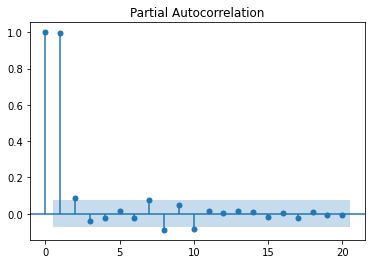

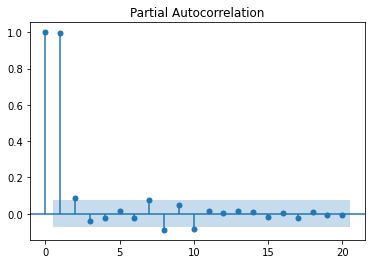

In [360]:
# plot PACF for daily prices

plot_pacf(sp_price['Adj Close'], lags=20)

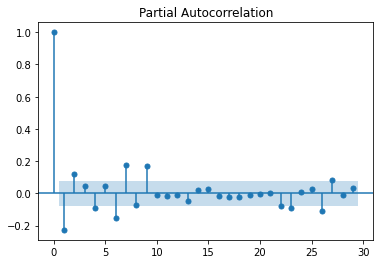

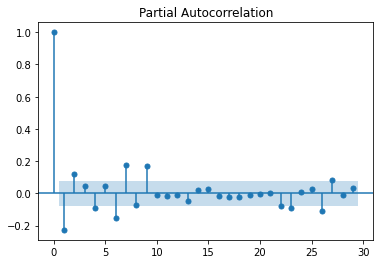

In [361]:
# plot PACF for daily difference in price
plot_pacf(sp_price['Adj Close'].diff().dropna())

Daily SP500 daily price difference appears to have a significant PACF at p=1,2,3,6,7,8,9

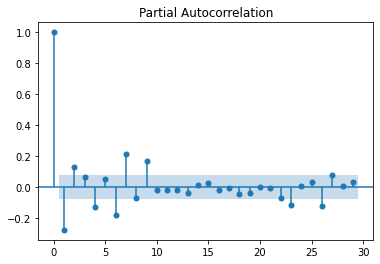

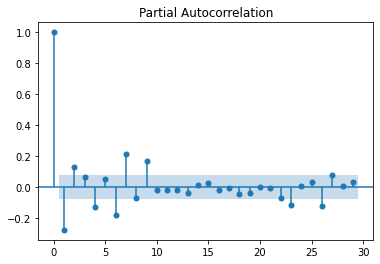

In [362]:
# plot PACF for daily return

plot_pacf(sp_price.pct_change_1.dropna())

Daily SP500 returns appear to have a significant PACF at p=1,2,3,6,7,8,9

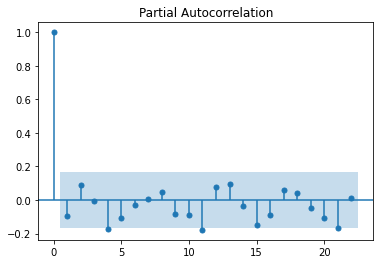

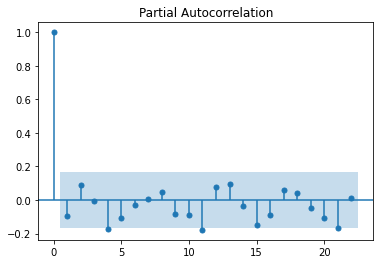

In [363]:
# plot PACF for weekly return
plot_pacf(sp_weekly_returns)

Weekly SP500 returns appear to have no significant PACF

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/li

Text(0, 0.5, 'Bayesian Information Criterion')

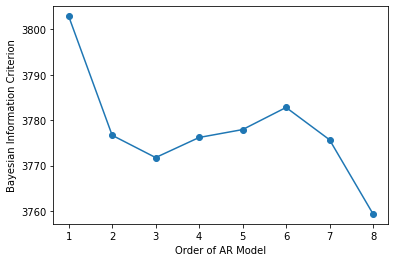

In [364]:
# Check BIC measure for different AR(p) processes for SP500 prices

BIC = np.zeros(9)
for p in range(9):
    mod = ARMA(sp_price['Adj Close'], order=(p,0))
    res = mod.fit()
    BIC[p] = res.bic

    # Plot the BIC as a function of p
plt.plot(range(1,9), BIC[1:9], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')

It appers there a low BIC value at p=3 but p=8 is lower for SP500 prices

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/li

Text(0, 0.5, 'Bayesian Information Criterion')

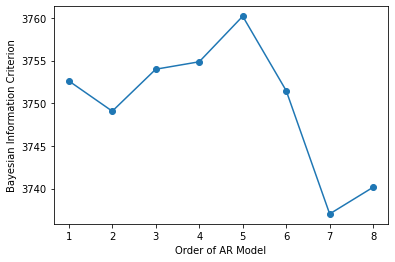

In [365]:
# Check BIC measure for different AR(p) processes for SP500 prices difference

BIC = np.zeros(9)
for p in range(9):
    mod = ARMA(sp_price['Adj Close'].diff().dropna(), order=(p,0))
    res = mod.fit()
    BIC[p] = res.bic

    # Plot the BIC as a function of p
plt.plot(range(1,9), BIC[1:9], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')

It appers there a low BIC value at p=2 but p=7 is lower for SP500 price differences

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  """
/Users/davidlam/opt/anaconda3/li

Text(0, 0.5, 'Bayesian Information Criterion')

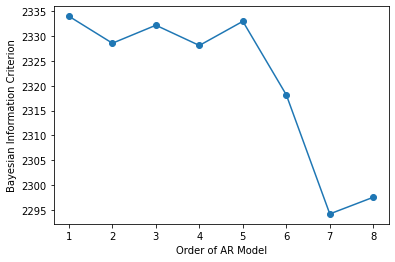

In [366]:
# Check BIC measure for different AR(p) processes for SP500 daily returns

BIC = np.zeros(9)
for p in range(9):
    mod = ARMA(sp_price.pct_change_1.dropna(), order=(p,0))
    res = mod.fit()
    BIC[p] = res.bic

    # Plot the BIC as a function of p
plt.plot(range(1,9), BIC[1:9], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')

It appers there a low BIC value p=7 for SP500 daily returns

Text(0, 0.5, 'Bayesian Information Criterion')

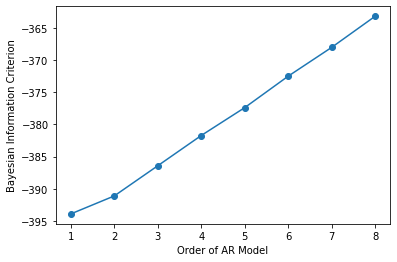

In [367]:
# Check BIC measure for different AR(p) processes for SP500 weekly returns

BIC = np.zeros(9)
for p in range(9):
    mod = ARMA(jd_weekly_returns, order=(p,0))
    res = mod.fit()
    BIC[p] = res.bic

    # Plot the BIC as a function of p
plt.plot(range(1,9), BIC[1:9], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')

Consistent with the PACF plot, no BIC is lowest at p=1

**Findings:**


It seems based on lowest BIC measure, the daily S&P500 returns are lowest when p=7. Perhaps this is a AR(7) model?

#### 2.4.2.6 SP500: Forecasting with an AR(7) model<a id='2.4.2.6_sp_forecasting_model'></a>

In [368]:
test = sp_price.pct_change_1.div(100).dropna()
test.index = pd.DatetimeIndex(test.index).to_period('B')
test.index

test.index[-20], test.index[-1]

(Period('2021-07-26', 'B'), Period('2021-08-20', 'B'))

In [369]:
# Fit an AR(7) model to the SP500 daily returns data
mod = ARMA(test, order=(7,0))
res = mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:           pct_change_1   No. Observations:                  664
Model:                     ARMA(7, 0)   Log Likelihood                1939.979
Method:                       css-mle   S.D. of innovations              0.013
Date:                Sat, 28 Aug 2021   AIC                          -3861.958
Time:                        12:36:11   BIC                          -3821.474
Sample:                    01-03-2019   HQIC                         -3846.271
                         - 08-20-2021                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0010      0.000      2.119      0.034    7.84e-05       0.002
ar.L1.pct_change_1    -0.1877      0.038     -4.947      0.000      -0.262      -0.113
ar.L2.pct_change_1  

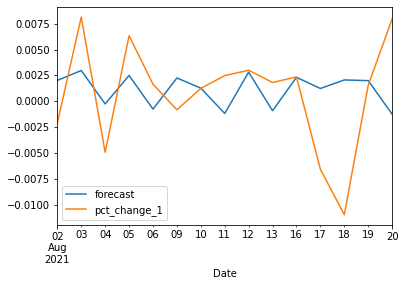

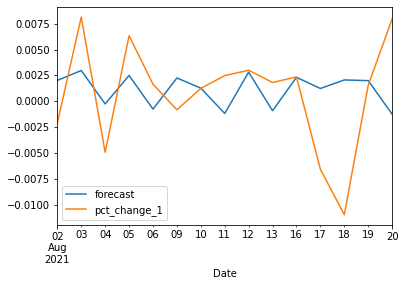

In [370]:
# forecast daily returns

res.plot_predict(start='2021-08-02', end='2021-08-20')

In [371]:
results_df = pd.concat([test,res.predict()],axis=1)
results_df.columns = ['pct_change_1', 'predicted_pct_change_1']
results_df.tail()

,pct_change_1,predicted_pct_change_1
Date,,
2021-08-16,0.002355,0.002317
2021-08-17,-0.006555,0.001239
2021-08-18,-0.010945,0.002063
2021-08-19,0.001548,0.001999
2021-08-20,0.007957,-0.001239


In [372]:
residuals = res.resid
mean_absolute_error = np.mean(np.abs(residuals))
mean_absolute_error

0.008501718099104487

The MAE is 85bps which is quite large error for a daily return.

In [373]:
# get diagnostics plots

#res.plot_diagnostics

In [374]:
res

The forecast does not appear to capture the volatility of the SP500

### 2.4.3 Cointegration of JD and SP500<a id='2.4.3_sp_jd'></a>

In [375]:
# lets regress JD.com price onto SP500

jd_series = jd_price[['Adj Close']]
sp_series = sp_price[['Adj Close']]

sp_series = sm.tools.tools.add_constant(sp_series)

results = sm.regression.linear_model.OLS(jd_series, sp_series).fit()

# Compute ADF

b = results.params[1]

adf_stats = adfuller(jd_series['Adj Close'] - b*sp_series['Adj Close'])
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  0.8696766596089283


/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  msg = (


**Findings**

The result of the dicky fuller test shows that JD and SP500 are not cointegrated. Perhaps we should try AMZN or Microsoft vs SP500 or AMZN vs MSFT

### 2.4.4 ARIMAX Model for SP500<a id='2.4.4_sp_arimax'></a>

Since we could not fit an AR model for JD.com, we focus on the SP500 for ARIMAX modeling. ARIMAX allows us to include exogenous variables to the time series analysis. We will test Volume and 1 day % change in volume

In [376]:
# Create 1 day percent change in volume as a feature.

sp_price['volume_pct_change_1'] = sp_price['Volume'].pct_change(1)

In [487]:
sp_arimax_data = sp_price.loc[:'2021-07-26', ['pct_change_1', 'Volume', 'volume_pct_change_1']]
sp_arimax_test = sp_price.loc['2021-07-26':, ['pct_change_1', 'Volume', 'volume_pct_change_1']]
sp_arimax_data.dropna(inplace=True)
sp_arimax_data.head()

,pct_change_1,Volume,volume_pct_change_1
Date,,,
2019-01-03,-2.386282,144140700,0.135635
2019-01-04,3.349563,142628800,-0.010489
2019-01-07,0.788481,103139100,-0.276870
2019-01-08,0.939539,102512600,-0.006074
2019-01-09,0.467343,95006600,-0.073220


In [488]:
# Fix datetime index to add frequency to remove error when running model

sp_arimax_data.index = pd.DatetimeIndex(sp_arimax_data.index).to_period('B')

In [489]:
# Instantiate ARIMAX model with AR(p) = 7 similar to our previous model

model1 = ARMA(sp_arimax_data['pct_change_1'], order = (7,0), exog=sp_arimax_data['Volume'])   # model1 is with exog=Volume

# Fit the model
results1 = model1.fit()

# Print model fit summary
print(results1.summary())

                              ARMA Model Results                              
Dep. Variable:           pct_change_1   No. Observations:                  645
Model:                     ARMA(7, 0)   Log Likelihood               -1076.038
Method:                       css-mle   S.D. of innovations              1.282
Date:                Sat, 28 Aug 2021   AIC                           2172.076
Time:                        14:39:30   BIC                           2216.768
Sample:                    01-03-2019   HQIC                          2189.417
                         - 07-26-2021                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6385      0.048     13.229      0.000       0.544       0.733
Volume             -6.426e-09   2.69e-08     -0.239      0.811   -5.92e-08    4.63e-08
ar.L1.pct_change_1  

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [490]:
# Instantiate ARIMAX model with AR(p) = 7 similar to our previous model

model2 = ARMA(sp_arimax_data['pct_change_1'], order = (7,0), exog=sp_arimax_data['volume_pct_change_1'])   # model1 is with exog=Volume

# Fit the model
results2 = model2.fit()

# Print model fit summary
print(results2.summary())

                              ARMA Model Results                              
Dep. Variable:           pct_change_1   No. Observations:                  645
Model:                     ARMA(7, 0)   Log Likelihood               -1064.630
Method:                       css-mle   S.D. of innovations              1.260
Date:                Sat, 28 Aug 2021   AIC                           2149.259
Time:                        14:39:33   BIC                           2193.952
Sample:                    01-03-2019   HQIC                          2166.600
                         - 07-26-2021                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1616      0.049      3.320      0.001       0.066       0.257
volume_pct_change_1    -1.0661      0.138     -7.733      0.000      -1.336      -0.796
ar.L1.pct_change

**Results and Findings**

Volume was not significant in this time series prediction. The volume_pct_change_1 variable was significant with p-value of 0

In [491]:
print('Model 1 BIC is: ' + str(results1.bic)), print('Model 2 BIC is: ' + str(results2.bic))

Model 1 BIC is: 2216.7680681324155
Model 2 BIC is: 2193.951681005178


(None, None)

Model 2 has a lower BIC and is the better model

### 2.4.5 SARIMAX Model for SP500<a id='2.4.5_sp_sarimax'></a>

Recreate the model2 with SARIMAX so we can perform forecasting.

#### 2.4.5.1 SP500 One Step Ahead in sample forecast<a id='2.4.5.1_sp_sarimax_1day'></a>

In [526]:
model3 = SARIMAX(sp_arimax_data['pct_change_1'], order=(7,0,0), exog=sp_arimax_data['volume_pct_change_1'], trend ='c')

# Make predictions
results3 = model3.fit()

# Make in-sample prediction
forecast = results3.get_prediction(start=-25)

# forecast mean

mean_forecast = forecast.predicted_mean

# Get confidence intervals of forecast

confidence_intervals = forecast.conf_int()

In [493]:
mean_forecast_df = pd.DataFrame(mean_forecast)
#mean_forecast_df = mean_forecast_df.reset_index()

In [494]:
mean_forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 25 entries, 2021-06-21 to 2021-07-26
Freq: B
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   predicted_mean  25 non-null     float64
dtypes: float64(1)
memory usage: 400.0 bytes


In [495]:
mean_forecast_df.index = mean_forecast.index.strftime('%Y-%m-%d')
mean_forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 2021-06-21 to 2021-07-26
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   predicted_mean  25 non-null     float64
dtypes: float64(1)
memory usage: 400.0+ bytes


In [496]:
# lets look at the confidence intervals dataframe

confidence_intervals.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 25 entries, 2021-06-21 to 2021-07-26
Freq: B
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lower pct_change_1  25 non-null     float64
 1   upper pct_change_1  25 non-null     float64
dtypes: float64(2)
memory usage: 600.0 bytes


In [497]:
confidence_intervals.index = confidence_intervals.index.strftime('%Y-%m-%d')


In [498]:
sp_arimax_data_plot = sp_arimax_data
sp_arimax_data_plot.index = sp_arimax_data_plot.index.strftime('%Y-%m-%d')
sp_arimax_data_plot = sp_arimax_data_plot.tail(25)

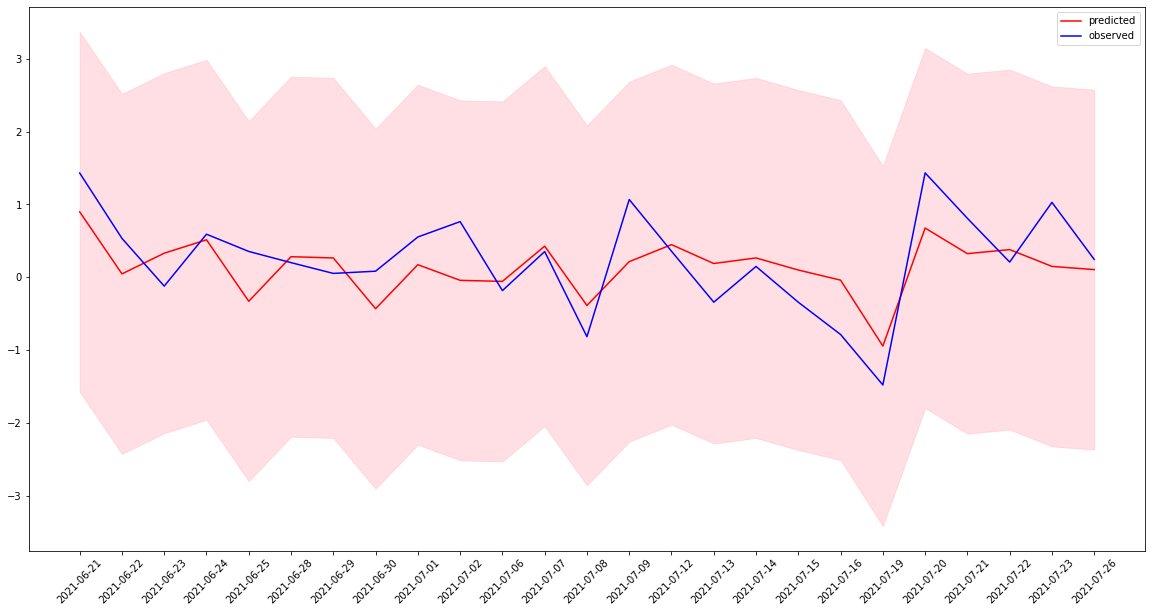

In [499]:
# Plot forecast

plt.figure(figsize=(20,10))
plt.xticks(rotation=45)

plt.plot(mean_forecast_df.predicted_mean, color='red', label='forecast')
plt.plot(sp_arimax_data_plot['pct_change_1'], color='blue')
plt.legend(['predicted', 'observed'])

# Shade unvertainty area

plt.fill_between(confidence_intervals.index,confidence_intervals['lower pct_change_1'], confidence_intervals['upper pct_change_1'], color='pink', alpha=0.5)

Looking at this grahically, the one day ahead predictions appear to be fairly close to observed values.

#### 2.4.5.2 SP500 in sample Dynamic forecast<a id='2.4.5.2_sp_sarimax_dynamic'></a>

In [500]:
# Fix datetime index to add frequency to remove error when running model

sp_arimax_data.index = pd.DatetimeIndex(sp_arimax_data.index).to_period('B')

In [501]:
# Now we try to make a dynamic prediction

model4 = SARIMAX(sp_arimax_data['pct_change_1'], order=(7,0,0), exog=sp_arimax_data['volume_pct_change_1'], trend ='c')

# Make predictions
results4 = model4.fit()

# Make in-sample prediction
forecast4 = results4.get_prediction(start=-25, dynamic=True)

# forecast mean

mean_forecast4 = forecast4.predicted_mean

# Get confidence intervals of forecast

confidence_intervals4 = forecast4.conf_int()

In [502]:
mean_forecast4_df = pd.DataFrame(mean_forecast4)
mean_forecast4_df.index = mean_forecast4.index.strftime('%Y-%m-%d')
confidence_intervals4.index = confidence_intervals4.index.strftime('%Y-%m-%d')

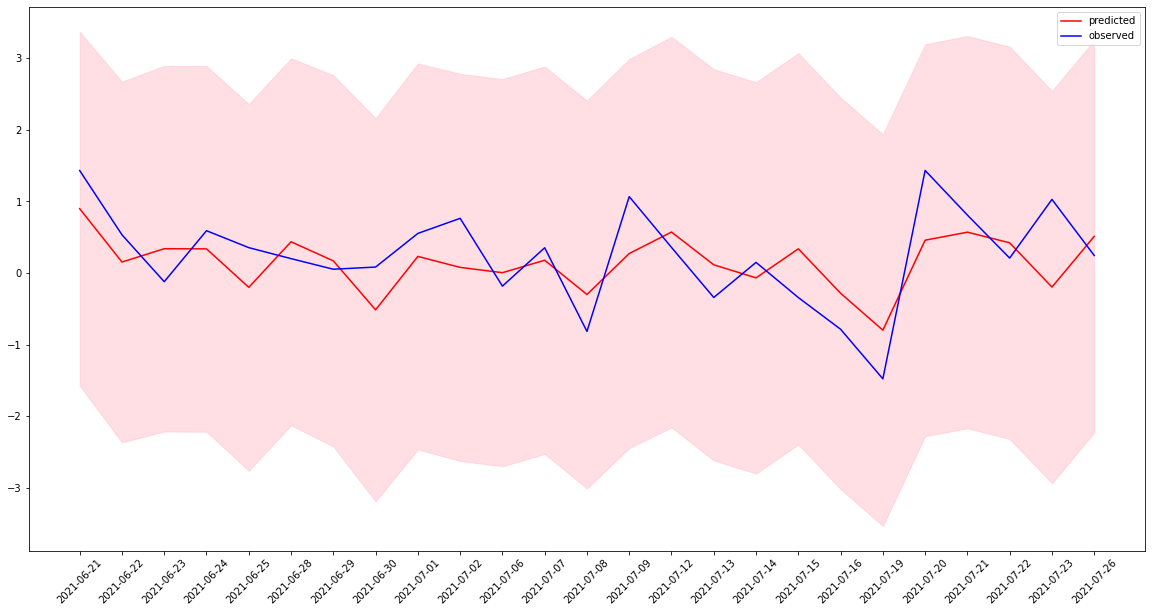

In [503]:
# Plot forecast

plt.figure(figsize=(20,10))
plt.xticks(rotation=45)

plt.plot(mean_forecast4_df.predicted_mean, color='red', label='forecast')
plt.plot(sp_arimax_data_plot['pct_change_1'], color='blue')
plt.legend(['predicted', 'observed'])

# Shade unvertainty area

plt.fill_between(confidence_intervals4.index,confidence_intervals4['lower pct_change_1'], confidence_intervals4['upper pct_change_1'], color='pink', alpha=0.5)

#### 2.4.5.3 SP500 Out of sample forecast<a id='2.4.5.3_sp_sarimax_out'></a>

In [544]:
sp_arimax_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2021-07-26 to 2021-08-20
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pct_change_1         20 non-null     float64
 1   Volume               20 non-null     int64  
 2   volume_pct_change_1  20 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 640.0+ bytes


In [504]:
# Fix datetime index to add frequency to remove error when running model

sp_arimax_test.index = pd.DatetimeIndex(sp_arimax_test.index).to_period('B')

In [505]:
sp_arimax_test.index = sp_arimax_test.index.strftime('%Y-%m-%d')

In [553]:
model5 = SARIMAX(sp_arimax_data['pct_change_1'], order=(7,0,0),trend ='c')
#exog=sp_arimax_data['volume_pct_change_1']
# Make predictions
results5 = model5.fit()

# Make in-sample prediction
#forecast5 = results5.get_forecast(steps=20, exog=sp_arimax_test['volume_pct_change_1'])

forecast5 = results5.get_prediction(start='2021-07-26', end='2021-08-20')
#, exog=sp_arimax_test['volume_pct_change_1']
# forecast mean

mean_forecast5 = forecast5.predicted_mean

# Get confidence intervals of forecast

confidence_intervals5 = forecast5.conf_int()

In [555]:
mean_forecast5

2021-06-23   -0.079220
2021-06-24    0.147632
2021-06-25   -0.370637
2021-06-28    0.310605
2021-06-29    0.102688
2021-06-30    0.006595
2021-07-01    0.353011
2021-07-02    0.061268
2021-07-05    0.213179
2021-07-06   -0.027070
2021-07-07    0.168145
2021-07-08    0.091404
2021-07-09    0.049178
2021-07-12    0.185484
2021-07-13    0.056014
2021-07-14    0.164506
2021-07-15    0.060927
2021-07-16    0.129846
2021-07-19    0.105169
2021-07-20    0.080927
2021-07-21    0.138089
2021-07-22    0.077023
2021-07-23    0.132918
2021-07-26    0.088080
2021-07-27    0.114845
2021-07-28    0.108260
2021-07-29    0.094840
2021-07-30    0.120656
2021-08-02    0.091831
2021-08-03    0.118074
2021-08-04    0.098564
2021-08-05    0.109129
2021-08-06    0.107999
2021-08-09    0.100821
2021-08-10    0.112960
2021-08-11    0.099506
2021-08-12    0.111436
2021-08-13    0.102987
2021-08-16    0.107097
2021-08-17    0.107333
2021-08-18    0.103576
2021-08-19    0.109356
2021-08-20    0.103134
Freq: B, Na

In [556]:
mean_forecast5_df = pd.DataFrame(mean_forecast5)
mean_forecast5_df.index = mean_forecast5.index.strftime('%Y-%m-%d')
confidence_intervals5.index = confidence_intervals5.index.strftime('%Y-%m-%d')

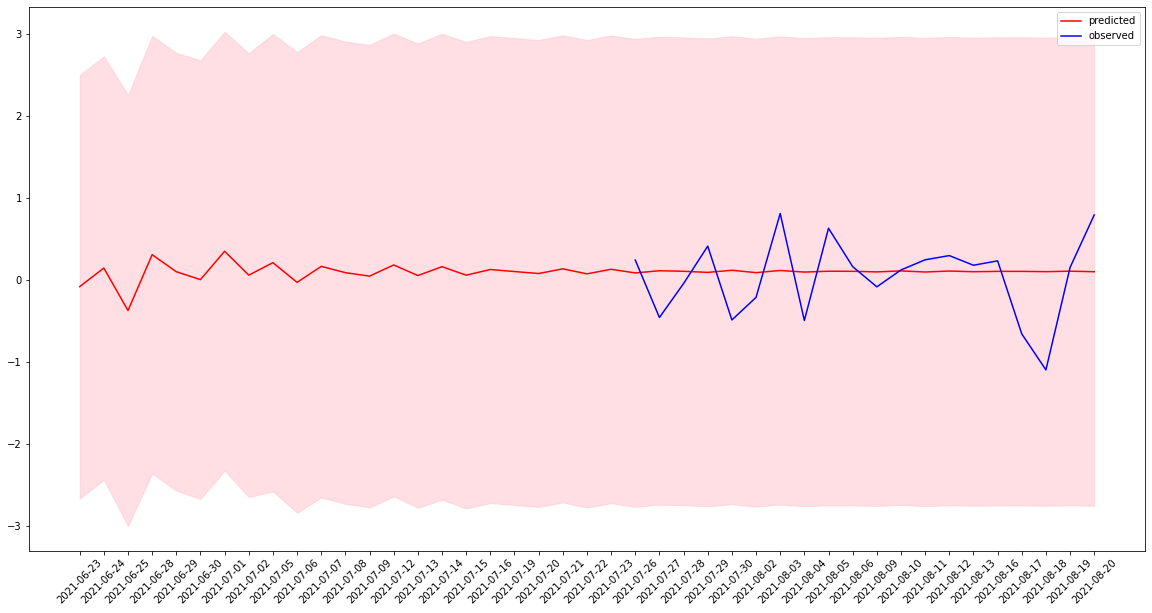

In [557]:
# Plot forecast

plt.figure(figsize=(20,10))
plt.xticks(rotation=45)

plt.plot(mean_forecast5_df.predicted_mean, color='red', label='forecast')
plt.plot(sp_arimax_test['pct_change_1'], color='blue')
plt.legend(['predicted', 'observed'])

# Shade unvertainty area

plt.fill_between(confidence_intervals5.index,confidence_intervals5['lower pct_change_1'], confidence_intervals5['upper pct_change_1'], color='pink', alpha=0.5)

**Some thing is off here. Need to understand what is happening and how can i predict/forecast out of sample values with SARIMAX and exogenous variables.**

## 2.5 ARCH and GARCH Model<a id='2.5_garch'></a>

In [568]:
sp_garch_data = sp_arimax_data
sp_garch_data.index = sp_garch_data.index.strftime('%Y-%m-%d') # fix date so it's not a period for ploting
sp_garch_data.info()

# create test dataset
sp_garch_test = sp_arimax_test

<class 'pandas.core.frame.DataFrame'>
Index: 645 entries, 2019-01-03 to 2021-07-26
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pct_change_1         645 non-null    float64
 1   Volume               645 non-null    int64  
 2   volume_pct_change_1  645 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 20.2+ KB


In [569]:
# Specify GARCH model assumptions
basic_gm = arch_model(sp_garch_data['pct_change_1'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

# Display model fitting summary
print(gm_result.summary())



Iteration:      4,   Func. Count:     27,   Neg. LLF: 889.966977792967
Iteration:      8,   Func. Count:     50,   Neg. LLF: 889.58575315945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 889.5857515420125
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           pct_change_1   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -889.586
Distribution:                  Normal   AIC:                           1787.17
Method:            Maximum Likelihood   BIC:                           1805.05
                                        No. Observations:                  645
Date:                Sat, Aug 28 2021   Df Residuals:                      644
Time:             

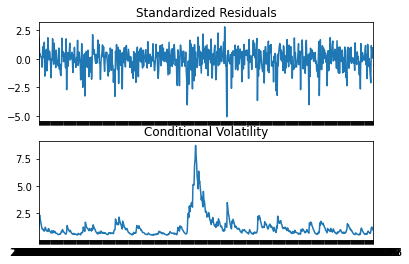

In [570]:
# Plot fitted results
gm_result.plot()
plt.show()

In [571]:
# Forecast Variance

gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                 h.1      h.2       h.3       h.4      h.5
Date                                                      
2021-07-26  0.667096  0.71974  0.772161  0.824361  0.87634


/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


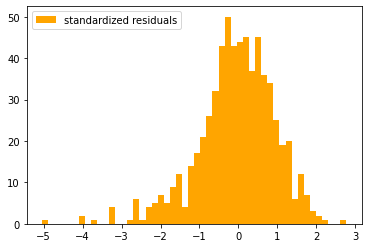

In [573]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.hist(gm_std_resid, bins = 50, 
         facecolor = 'orange', label = 'standardized residuals')

plt.legend(loc = 'upper left')



The residuals appear slightly negatively skewed. Let's see if we can improve this.

In [574]:
# Specify GARCH model assumptions
skewt_gm = arch_model(sp_garch_data['pct_change_1'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')
# Fit the model
skewt_result = skewt_gm.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 41615.43777626594
Iteration:      2,   Func. Count:     18,   Neg. LLF: 56981.43029574679
Iteration:      3,   Func. Count:     27,   Neg. LLF: 16579.909393764363
Iteration:      4,   Func. Count:     35,   Neg. LLF: 19153.056936516077
Iteration:      5,   Func. Count:     43,   Neg. LLF: 877.6627086388288
Iteration:      6,   Func. Count:     51,   Neg. LLF: 862.8987564167082
Iteration:      7,   Func. Count:     59,   Neg. LLF: 1119.2126393510316
Iteration:      8,   Func. Count:     68,   Neg. LLF: 862.3861779360948
Iteration:      9,   Func. Count:     76,   Neg. LLF: 861.8673682798453
Iteration:     10,   Func. Count:     84,   Neg. LLF: 861.4834211895654
Iteration:     11,   Func. Count:     91,   Neg. LLF: 861.478859076647
Iteration:     12,   Func. Count:     98,   Neg. LLF: 861.477590867038
Iteration:     13,   Func. Count:    105,   Neg. LLF: 861.4775641974602
Iteration:     14,   Func. Count:    111,   Neg. LLF: 861.47756

In [575]:

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

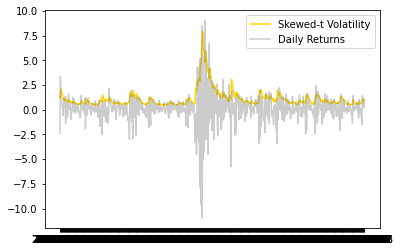

In [577]:
# Plot model fitting results
plt.plot(skewt_vol, color = 'gold', label = 'Skewed-t Volatility')
plt.plot(sp_garch_data['pct_change_1'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

The skewed Student's t-distribution assumption gives us a GARCH model in line with actual observations

Most practitioners prefer to separate the mean and volatility models. We will not do that here but that is a future step. We also want to address the asymmetry issue with stock market returns since volatility in down markets is higher than in upmarkets.

In [588]:
# Perform fixed rolling window forecast

forecasts = {}

for i in range(20):
    # Specify fixed rolling window size for model fitting
    skewt_result = skewt_gm.fit(first_obs = i + 505, 
                             last_obs = i + 625, update_freq = 5)
    # Conduct 1-period variance forecast and save the result
    temp_result = skewt_result.forecast(horizon = 1).variance
    fcast = temp_result.iloc[i + 625]
    forecasts[fcast.name] = fcast
# Save all forecast to a DataFrame    
forecast_var = pd.DataFrame(forecasts).T





Iteration:      5,   Func. Count:     42,   Neg. LLF: 144.02491901365195
Iteration:     10,   Func. Count:     80,   Neg. LLF: 142.68654784930797
Iteration:     15,   Func. Count:    115,   Neg. LLF: 142.68524223715255
Optimization terminated successfully    (Exit mode 0)
            Current function value: 142.68524223715255
            Iterations: 16
            Function evaluations: 121
            Gradient evaluations: 16
Iteration:      5,   Func. Count:     42,   Neg. LLF: 152.02273807897015
Iteration:     10,   Func. Count:     81,   Neg. LLF: 142.10802049417282
Iteration:     15,   Func. Count:    116,   Neg. LLF: 142.1079805511157
Optimization terminated successfully    (Exit mode 0)
            Current function value: 142.1079805511157
            Iterations: 15
            Function evaluations: 116
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     42,   Neg. LLF: 16135.684294477971
Iteration:     10,   Func. Count:     80,   Neg. LLF: 141.30045233758

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set r

Iteration:     10,   Func. Count:     81,   Neg. LLF: 139.23472669020907
Iteration:     15,   Func. Count:    116,   Neg. LLF: 139.21934918969328
Optimization terminated successfully    (Exit mode 0)
            Current function value: 139.21934918969328
            Iterations: 16
            Function evaluations: 122
            Gradient evaluations: 16
Iteration:      5,   Func. Count:     44,   Neg. LLF: 3158.894843320736
Iteration:     10,   Func. Count:     81,   Neg. LLF: 139.06625250414695
Iteration:     15,   Func. Count:    116,   Neg. LLF: 139.056543864976
Optimization terminated successfully    (Exit mode 0)
            Current function value: 139.056543864976
            Iterations: 16
            Function evaluations: 122
            Gradient evaluations: 16
Iteration:      5,   Func. Count:     44,   Neg. LLF: 155.18871551911533
Iteration:     10,   Func. Count:     82,   Neg. LLF: 138.72327909860167
Iteration:     15,   Func. Count:    117,   Neg. LLF: 138.72296432641917

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set r

Iteration:     15,   Func. Count:    117,   Neg. LLF: 138.8610467523792
Optimization terminated successfully    (Exit mode 0)
            Current function value: 138.86104308068576
            Iterations: 17
            Function evaluations: 130
            Gradient evaluations: 17
Iteration:      5,   Func. Count:     42,   Neg. LLF: 162.42743973041615
Iteration:     10,   Func. Count:     81,   Neg. LLF: 138.41031974678054
Iteration:     15,   Func. Count:    116,   Neg. LLF: 138.40943740951275
Optimization terminated successfully    (Exit mode 0)
            Current function value: 138.40943198587024
            Iterations: 17
            Function evaluations: 129
            Gradient evaluations: 17
Iteration:      5,   Func. Count:     42,   Neg. LLF: 454.8413538659321
Iteration:     10,   Func. Count:     83,   Neg. LLF: 139.14734421424177
Iteration:     15,   Func. Count:    118,   Neg. LLF: 139.1456775426001
Optimization terminated successfully    (Exit mode 0)
            Curr

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set r

Iteration:     15,   Func. Count:    116,   Neg. LLF: 138.9092471385711
Optimization terminated successfully    (Exit mode 0)
            Current function value: 138.90831002714054
            Iterations: 19
            Function evaluations: 143
            Gradient evaluations: 19
Iteration:      5,   Func. Count:     42,   Neg. LLF: 160.0130175035597
Iteration:     10,   Func. Count:     80,   Neg. LLF: 138.53054033719894
Iteration:     15,   Func. Count:    115,   Neg. LLF: 138.51983625614406
Optimization terminated successfully    (Exit mode 0)
            Current function value: 138.51967678906155
            Iterations: 19
            Function evaluations: 142
            Gradient evaluations: 19
Iteration:      5,   Func. Count:     42,   Neg. LLF: 4953.662668228339
Iteration:     10,   Func. Count:     80,   Neg. LLF: 137.70529382792074
Iteration:     15,   Func. Count:    115,   Neg. LLF: 137.70477836846285
Optimization terminated successfully    (Exit mode 0)
            Curr

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set r

Iteration:     15,   Func. Count:    116,   Neg. LLF: 137.08972315988265
Iteration:     20,   Func. Count:    151,   Neg. LLF: 136.9638480214606
Iteration:     25,   Func. Count:    186,   Neg. LLF: 136.93764916662087
Iteration:     30,   Func. Count:    233,   Neg. LLF: 136.93745221688673
Optimization terminated successfully    (Exit mode 0)
            Current function value: 136.93745217834294
            Iterations: 31
            Function evaluations: 243
            Gradient evaluations: 31
Iteration:      5,   Func. Count:     41,   Neg. LLF: 17343.178470289266
Iteration:     10,   Func. Count:     79,   Neg. LLF: 135.7546896444431
Iteration:     15,   Func. Count:    114,   Neg. LLF: 135.58979843846785
Iteration:     20,   Func. Count:    149,   Neg. LLF: 135.32471617596724
Iteration:     25,   Func. Count:    184,   Neg. LLF: 135.27692192112926
Optimization terminated successfully    (Exit mode 0)
            Current function value: 135.27692270251316
            Iterations: 2

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:     15,   Func. Count:    115,   Neg. LLF: 135.2715823844868
Iteration:     20,   Func. Count:    150,   Neg. LLF: 135.09573720451604
Iteration:     25,   Func. Count:    185,   Neg. LLF: 135.0650517556433
Iteration:     30,   Func. Count:    233,   Neg. LLF: 135.0616000954398
Optimization terminated successfully    (Exit mode 0)
            Current function value: 135.0615983075017
            Iterations: 30
            Function evaluations: 235
            Gradient evaluations: 30
Iteration:      5,   Func. Count:     42,   Neg. LLF: 4754.085173685109
Iteration:     10,   Func. Count:     80,   Neg. LLF: 133.92059523478247
Iteration:     15,   Func. Count:    115,   Neg. LLF: 133.65634862307866
Iteration:     20,   Func. Count:    150,   Neg. LLF: 133.59653463439952
Iteration:     25,   Func. Count:    186,   Neg. LLF: 166.44215818876842
Iteration:     30,   Func. Count:    229,   Neg. LLF: 133.58905463650677
Optimization terminated successfully    (Exit mode 0)
          

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:     15,   Func. Count:    116,   Neg. LLF: 132.90726001167488
Iteration:     20,   Func. Count:    151,   Neg. LLF: 132.81895800799285
Iteration:     25,   Func. Count:    187,   Neg. LLF: 132.80529314440776
Iteration:     30,   Func. Count:    226,   Neg. LLF: 132.80082030075522
Optimization terminated successfully    (Exit mode 0)
            Current function value: 132.80092321305102
            Iterations: 31
            Function evaluations: 237
            Gradient evaluations: 31


/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


<AxesSubplot:>

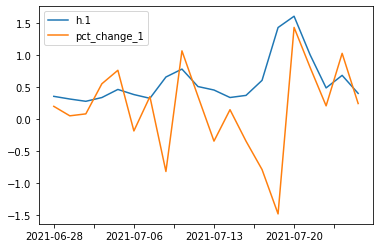

In [591]:
forecast_compare = pd.concat([forecast_var, sp_garch_data.loc['2021-06-28':'2021-07-28','pct_change_1']], axis=1)
forecast_compare.plot()           

We can see based on this forecast that there is some asymmetry in volatility that we're not accounting for. It appears that using GARCH to model is very promising. Should explore this further.

## 2.6 Resources to Review for future analysis<a id='2.6_review'></a>

Datacamp Courses to look at:

For time series:
   
   * Manpulating Time Series Data in Python (**Completed first 3 chapters**)
   * Time Series Analysis in Python (**Completed**)
   * ARIMA Models in Python (**Completed**)
   * GARCH Models in Python (**Partially Completed**)
   * Machine Learning for Time Series Data in Python
   
For Twitter Sentiment Analysis

   * Analyzing Social Media Data in Python (**Completed first 2 chapters**)
   * Sentiment Analysis in Python

## Analysis to-do list

For Twitter Sentiment Analysis

   * Do a word count of SP500, JD and buy, sell etc...
   * Do sentiment analysis with polarity scores (**complete**)